In [3]:
%%capture
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install "monai-weekly[nibabel]"
!pip install -U pytorch-lightning
!pip install torchmetrics
!pip install -U tqdm
%matplotlib inline

In [4]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-441fcfc8-a968-839b-1c9a-f4ee2ee6b15d)


In [5]:
import tqdm
print(tqdm.__version__)
assert tqdm.__version__ >='4.47.0', 'tqdm version >=4.47.0'

4.61.1


In [6]:
#download data
import os
if os.path.isfile('./Task09_Spleen.tar') is False:
  !wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar

--2021-07-15 16:50:36--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 52.218.181.177
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|52.218.181.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610352640 (1.5G) [application/x-tar]
Saving to: ‘Task09_Spleen.tar’

Task09_Spleen.tar   100%[===================>]   1.50G  35.1MB/s    in 60s     

2021-07-15 16:51:37 (25.4 MB/s) - ‘Task09_Spleen.tar’ saved [1610352640/1610352640]



In [7]:
import tarfile
if os.path.isdir('./Task09_Spleen') is False:
  my_tar = tarfile.open('./Task09_Spleen.tar')
  my_tar.extractall('./')
  my_tar.close()

In [8]:
from glob import glob
import os
images = sorted(glob("./Task09_Spleen/imagesTr/*.nii.gz"))
segs = sorted(glob("./Task09_Spleen/labelsTr/*.nii.gz"))
data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, segs)
        ]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [9]:
import nibabel as nib
for i in range(len(train_files)):
  img = nib.load(train_files[i]['image']).get_fdata()
  lab = nib.load(train_files[i]['label']).get_fdata()
  print(img.shape,lab.shape)
  break

(512, 512, 55) (512, 512, 55)


In [10]:
import nibabel as nib
raw_val_data=[]
for i in range(len(val_files)):
  img = nib.load(val_files[i]['image']).get_fdata()
  lab = nib.load(val_files[i]['label']).get_fdata()
  print(img.shape,lab.shape)
  raw_val_data.append((img,lab))
  

(512, 512, 33) (512, 512, 33)
(512, 512, 50) (512, 512, 50)
(512, 512, 135) (512, 512, 135)
(512, 512, 97) (512, 512, 97)
(512, 512, 101) (512, 512, 101)
(512, 512, 80) (512, 512, 80)
(512, 512, 60) (512, 512, 60)
(512, 512, 31) (512, 512, 31)
(512, 512, 41) (512, 512, 41)


In [37]:
from  monai import transforms as T
train_transforms = T.Compose(
            [
                T.LoadImaged(keys=["image", "label"]),
                T.AddChanneld(keys=["image", "label"]),
                T.Spacingd(keys=["image", "label"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear", "nearest"),),
                T.Orientationd(keys=["image", "label"], axcodes="RAS"),
                T.ScaleIntensityd(keys=["image"]),
                T.CropForegroundd(keys=["image", "label"], source_key="image"),
                T.RandCropByPosNegLabeld(keys=["image", "label"],label_key="label",spatial_size=(64, 64, 64),pos=1,neg=1,
                    num_samples=8,image_key="image", image_threshold=0,),
                T.EnsureTyped(keys=["image", "label"]),
            ]
        )
val_transforms = T.Compose(
  [
      T.LoadImaged(keys=["image", "label"]),
      T.AddChanneld(keys=["image", "label"]),
      T.Spacingd(keys=["image", "label"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear", "nearest"),),
      T.Orientationd(keys=["image", "label"], axcodes="RAS"),
      T.ScaleIntensityd(keys=["image"]),
      T.CropForegroundd(keys=["image", "label"], source_key="image"),
      T.EnsureTyped(keys=["image", "label"]),
  ]
)

test_transforms = T.Compose(
  [
      T.LoadImaged(keys=["image"]),
      T.AddChanneld(keys=["image"]),
      T.Spacingd(keys=["image"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear"),),
      T.Orientationd(keys=["image"], axcodes="RAS"),
      T.ScaleIntensityd(keys=["image"]),
      T.CropForegroundd(keys=["image"], source_key="image"),
      T.EnsureTyped(keys=["image"]),
  ]
)

In [12]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from monai.losses import DiceLoss
from torch.utils.data import DataLoader, Dataset
from monai.data import CacheDataset, list_data_collate,decollate_batch
from pytorch_lightning.loggers import TensorBoardLogger
from monai.networks.nets import UNet
from monai.metrics import DiceMetric

import torch.nn as nn
import torch
import torchmetrics


In [13]:
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=2,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                      norm=Norm.BATCH,
                  )

  #parameters
    self.lr=1e-4
    self.bs=16
    self.numworker=2
    self.criterion = DiceLoss(to_onehot_y=True, softmax=True)
    self.post_pred = T.Compose([T.EnsureType(), T.AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
    self.post_label = T.Compose([T.EnsureType(), T.AsDiscrete(to_onehot=True, n_classes=2)])
    self.metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    self.metric1= DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    self.best_val_dice = 0
    self.best_val_epoch = 0

  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=self.bs, shuffle=True,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    out=self(image)
    loss=self.criterion(out,segment)

    self.log('train/loss', loss, on_epoch=False,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = CacheDataset(data=val_files, transform=val_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=1, shuffle=False,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    outputs = sliding_window_inference(image, roi_size, sw_batch_size, self.forward)
    loss=self.criterion(outputs,segment)
    outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
    labels = [self.post_label(i) for i in decollate_batch(segment)]
    self.metric(y_pred=outputs, y=labels)
    self.metric1(y_pred=outputs, y=labels)
    dice = self.metric1.aggregate().item()
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/dice', dice, on_epoch=True,prog_bar=True)
    return{"val_loss": loss, "val_number": len(outputs)}
  
  def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.metric.aggregate().item()
        self.metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

In [14]:
model = OurModel()
# logger = TensorBoardLogger("logs", name="my_logs")
# checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='./',
#                                       filename='spleen200' )
# trainer = Trainer(max_epochs=400, auto_lr_find=False, auto_scale_batch_size=False,
#                   #tpu_cores=8,precision=16,
#                   gpus=-1,precision=16,
#                   logger=logger,
#                   progress_bar_refresh_rate=30,
#                   #resume_from_checkpoint='/content/drive/MyDrive/spleen200-v1.ckpt',
#                   callbacks=[checkpoint_callback]
#                   )

In [15]:
# %%time
# trainer.fit(model)

In [16]:
# torch.save(model.state_dict(), './spleen_state200.pt')

In [17]:
# print(
#     f"train completed, best_metric: {model.best_val_dice:.4f} "
#     f"at epoch {model.best_val_epoch}")

In [18]:
model.load_state_dict(torch.load('../input/speen-3d-segmentation/spleen_state200.pt'))


<All keys matched successfully>

# inference

In [30]:
post_transforms = T.Compose([
        T.ToTensord(keys="pred"), 
        T.Activationsd(keys="pred", sigmoid=True),
        T.AsDiscreted(keys="pred", threshold_values=True),
        T.Invertd(
            keys=["pred",'label'],  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="image",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            meta_keys=["pred_meta_dict","label_meta_dict"],  # key field to save inverted meta data, every item maps to `keys`
            orig_meta_keys="image_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
        #SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ])

In [20]:
val_dataloader=model.val_dataloader()

Loading dataset: 100%|██████████| 9/9 [00:24<00:00,  2.71s/it]


In [31]:
from monai.data import decollate_batch
import matplotlib.pyplot as plt
import numpy as np
model.eval()
device = torch.device("cuda:0")
model.to(device)
post_data=[]
with torch.no_grad():
  for d in val_dataloader:
    images = d["image"].to(device)
    # define sliding window size and batch size for windows inference
    infer_outputs = sliding_window_inference(inputs=images, roi_size=(160 , 160, 160), sw_batch_size=2, predictor=model)
    infer_outputs = decollate_batch(infer_outputs)
    for (infer_output, infer_output_data) in zip(infer_outputs, decollate_batch(d)):
      infer_output_data["pred"] = infer_output
      post_data.append(post_transforms(infer_output_data))
      break
    break
    

In [32]:
out=post_data[0]
out['image'].shape,out['label'].shape,out['pred'].shape

(torch.Size([1, 239, 239, 113]),
 torch.Size([1, 512, 512, 33]),
 torch.Size([2, 512, 512, 33]))

In [33]:
raw_val=raw_val_data[0]
raw_val[0].shape,raw_val[1].shape#raw label and segment

((512, 512, 33), (512, 512, 33))

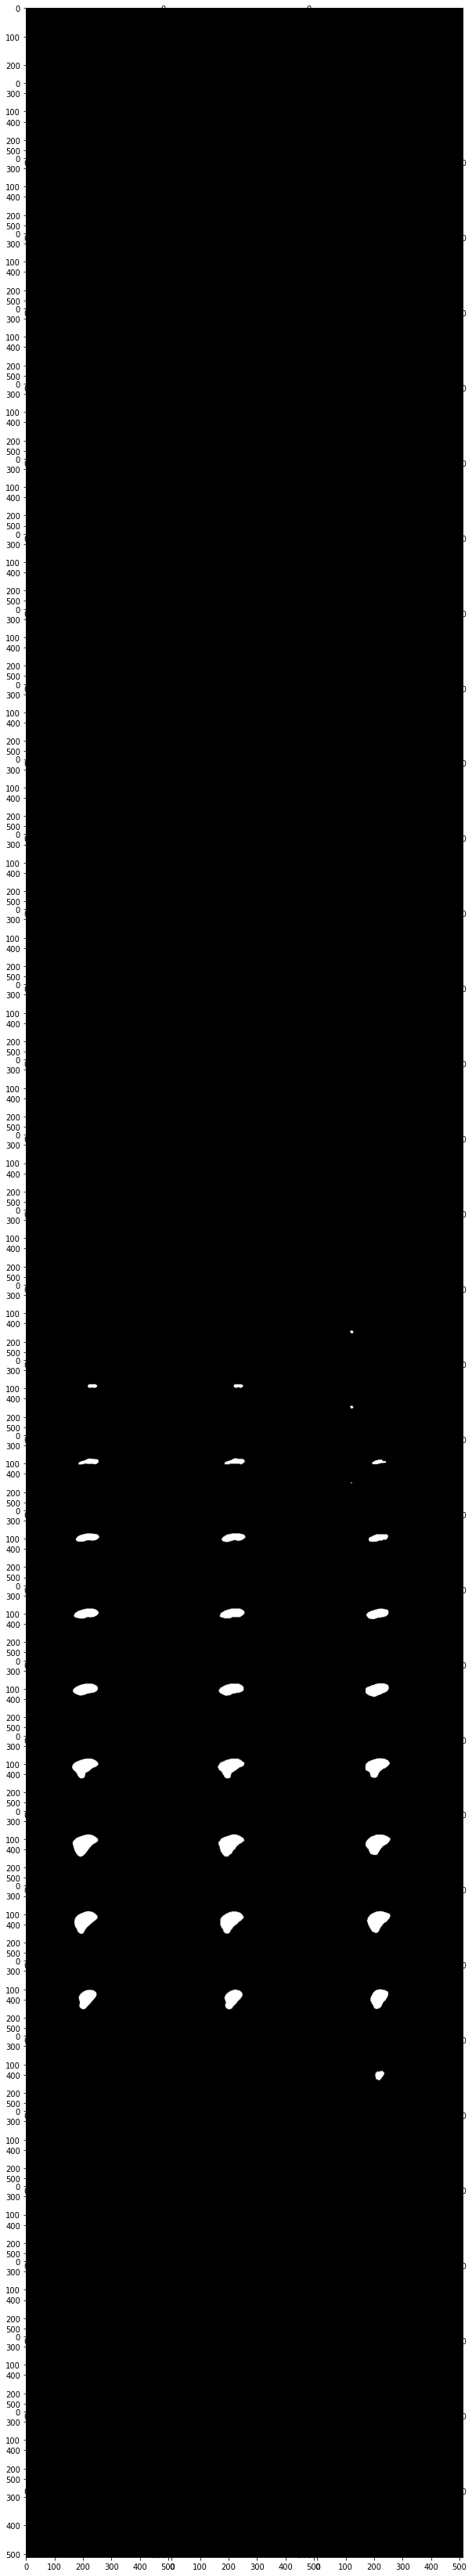

In [34]:
fig,ax=plt.subplots(33,3,figsize=(10,60))

for i in range(33):
  ax[i,0].imshow(raw_val[1][:,:,i],cmap='gray')#raw image
  ax[i,1].imshow(out['label'][0,:,:,i],cmap='gray')#inverted image
  ax[i,2].imshow(torch.argmax(out['pred'],0)[:,:,i],cmap='gray')#predicted image
plt.subplots_adjust(wspace=0, hspace=-.5)


# test

In [38]:
post_transforms = T.Compose([
        T.ToTensord(keys="pred"), 
        T.Activationsd(keys="pred", sigmoid=True),
        T.AsDiscreted(keys="pred", threshold_values=True),
        T.Invertd(
            keys=["pred"],  # invert the `pred` data field, also support multiple fields
            transform=test_transforms,
            orig_keys="image",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            meta_keys=["pred_meta_dict"],  # key field to save inverted meta data, every item maps to `keys`
            orig_meta_keys="image_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
        #SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ])

In [39]:
ds = CacheDataset(data=val_files, transform=test_transforms,cache_rate=1.0, num_workers=2)
test_loader=DataLoader(ds, batch_size=1, shuffle=False,num_workers=2, collate_fn=list_data_collate)


Loading dataset: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


In [41]:
sample=next(iter(test_loader))
sample['image'].shape

torch.Size([1, 1, 239, 239, 113])

In [42]:
post_data=[]
for d in test_loader:
    images = d["image"].to(device)
    # define sliding window size and batch size for windows inference
    infer_outputs = sliding_window_inference(inputs=images, roi_size=(160 , 160, 160), sw_batch_size=2, predictor=model)
    infer_outputs = decollate_batch(infer_outputs)
    for (infer_output, infer_output_data) in zip(infer_outputs, decollate_batch(d)):
      infer_output_data["pred"] = infer_output
      post_data.append(post_transforms(infer_output_data))
      break
    break

In [44]:
out=post_data[0]
out['image'].shape,out['pred'].shape

(torch.Size([1, 239, 239, 113]), torch.Size([2, 512, 512, 33]))

In [45]:
raw_val=raw_val_data[0]
raw_val[0].shape,raw_val[1].shape#raw label and segment

((512, 512, 33), (512, 512, 33))

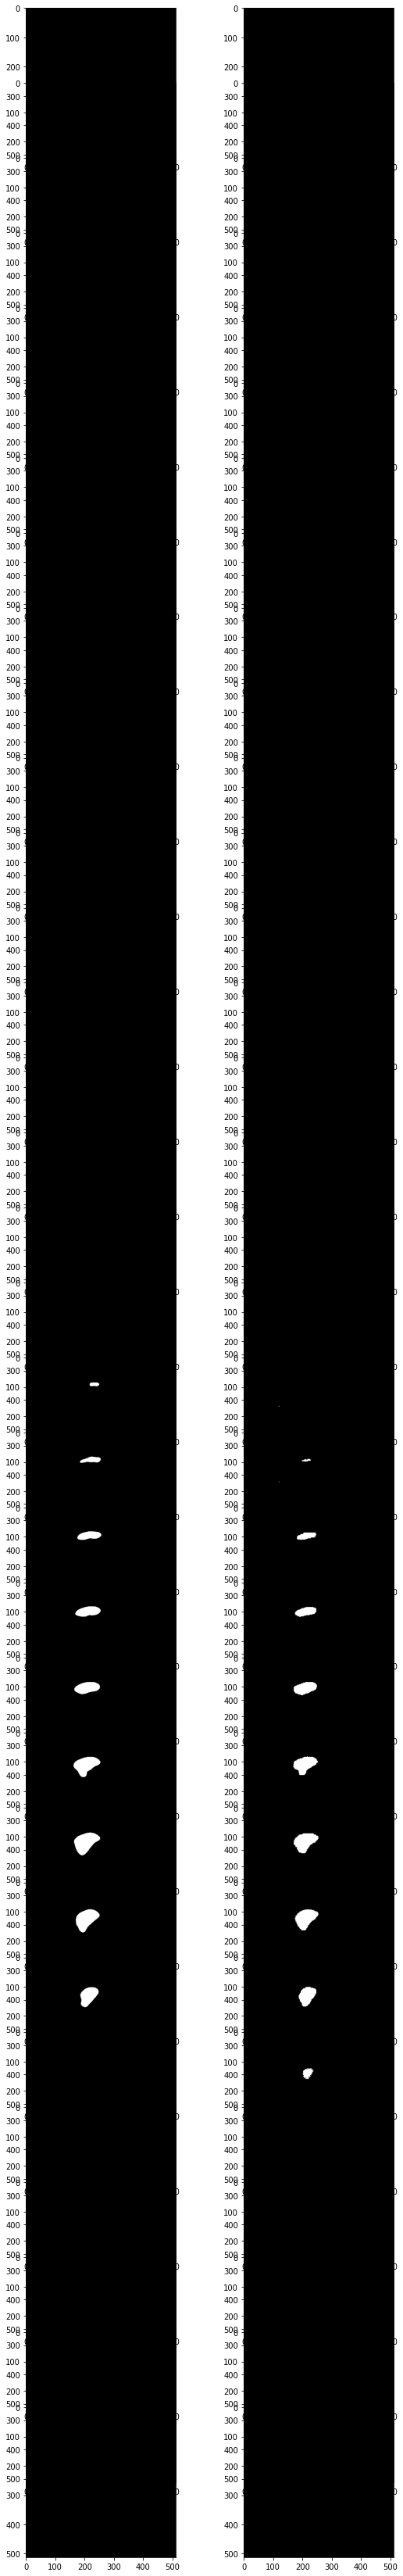

In [46]:
fig,ax=plt.subplots(33,2,figsize=(10,60))

for i in range(33):
  ax[i,0].imshow(raw_val[1][:,:,i],cmap='gray')#ground label 
  ax[i,1].imshow(torch.argmax(out['pred'],0)[:,:,i],cmap='gray')#predicted label
plt.subplots_adjust(wspace=0, hspace=-.5)


In [ ]:
# fig,ax=plt.subplots(33,3,figsize=(10,60))

# for i in range(33):
#   ax[i,0].imshow(raw_val[1][:,:,i],cmap='gray')#raw image
#   ax[i,1].imshow(out['label'][0,:,:,i],cmap='gray')#inverted image
#   ax[i,2].imshow(torch.argmax(out['pred'],0)[:,:,i],cmap='gray')#predicted image
# plt.subplots_adjust(wspace=0, hspace=-.5)


In [ ]:
!rm -rf ./Task09_Spleen
!rm ./Task09_Spleen.tar